## Hardware Testbed and Large-scale Testbed Co-simulation

## Co-Simulation

In [1]:
# --- imports ---

import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

import matplotlib.pyplot as plt
import scienceplots

from core import run

In [2]:
ss, cosim_out, status = run(case='ieee39_htb.xlsx', tf=50,
                            read_file = 'datar.txt', write_file = 'dataw.txt',
                            test_mode=True, AGC_control=True)

ANDES version: 1.8.7.post5+gb9281204
IO path: /home/jwang175/hlcosim/code/data
Output data path: /home/jwang175/hlcosim/output
Test mode: True
LTB: 39 bus; 10 generator; 5.8564 GW load.
HTB: PQ_2 is connected to bus 4 in LTB.

LTB ready, start HTB to continue...
Co-sim initialized.
LTB simulated to 10s...
LTB simulated to 20s...
LTB simulated to 30s...
LTB simulated to 40s...
LTB simulated to 50s...
Co-sim end at  51.0s.
Cosim data save as: output_20230408_2000.csv


In [3]:
# --- plot ---
cosim_plt = cosim_out.copy()
cosim_plt[['p', 'q']] = cosim_plt[['p', 'q']] * ss.config.mva   # p.u. to nominal value
cosim_plt[['tw', 'tr', 'tsim', 'tall']] = cosim_plt[['tw', 'tr', 'tsim', 'tall']] * 1000  # s to ms
cosim_plt['freq'] = cosim_plt['freq'] * ss.config.freq  # p.u. to Hz

In [4]:
%matplotlib inline

<Axes: xlabel='Time [s]', ylabel='Voltage [p.u.]'>

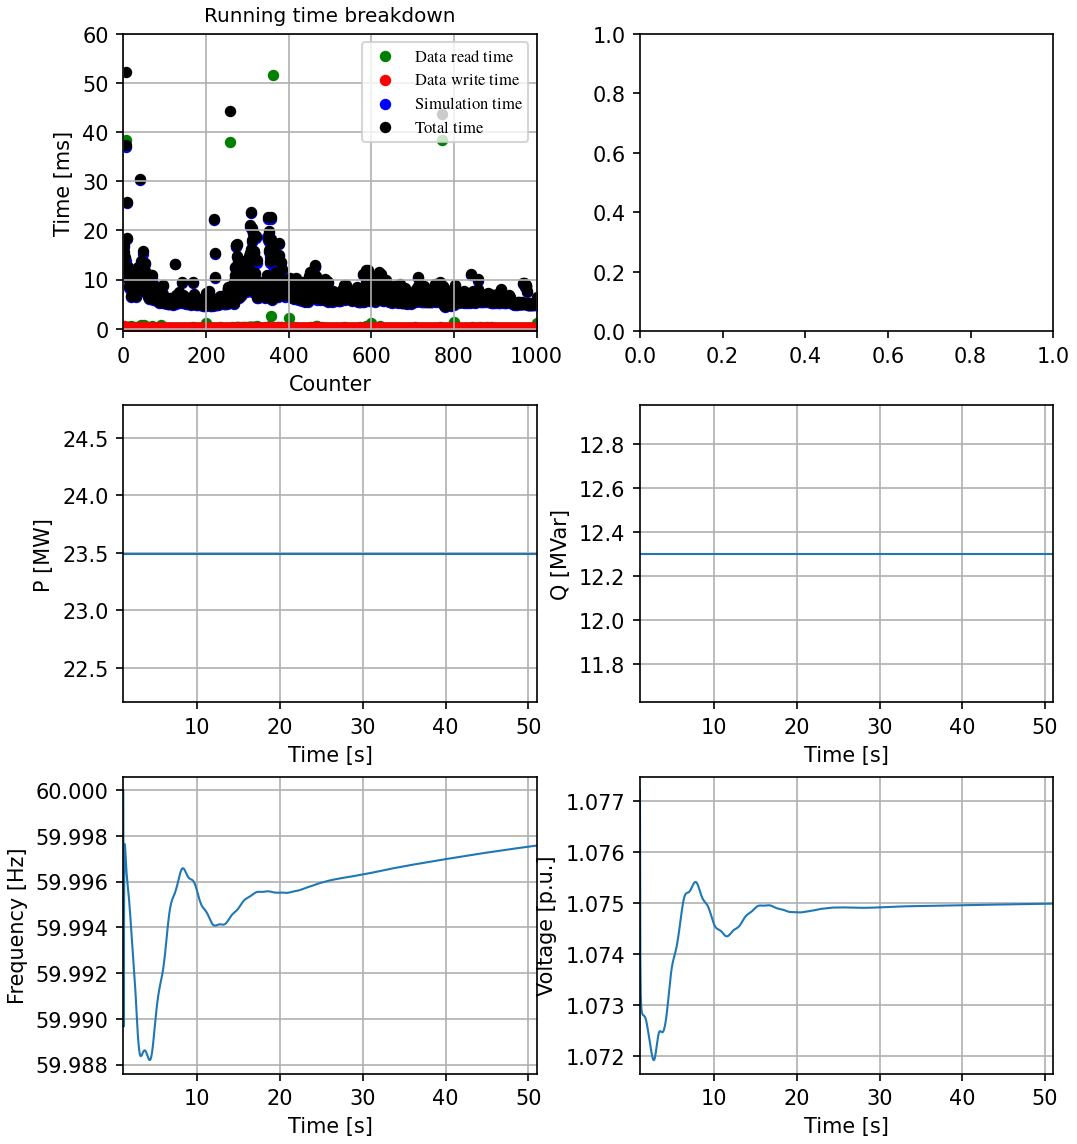

In [5]:
fig0, ax0 = plt.subplots(3, 2, figsize=(8, 9), dpi=150)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.style.use(['science', 'ieee'])

x, fig, ax = 'k', fig0, ax0[0, 0]
cosim_plt.plot.scatter(y='tw', color='green', label='Data read time', x=x, fig=fig, ax=ax)
cosim_plt.plot.scatter(y='tr', color='red', label='Data write time', x=x, fig=fig, ax=ax)
cosim_plt.plot.scatter(y='tsim', color='blue', label='Simulation time', x=x, fig=fig, ax=ax)
cosim_plt.plot.scatter(y='tall', color='black', label='Total time', x=x, fig=fig, ax=ax)

ax.legend(loc='upper right', frameon=True)
ax.set_xlabel('Counter')
ax.set_ylabel('Time [ms]')
ax.grid(True)
ax.set_title('Running time breakdown')
ax.set_xlim([-0.5, cosim_plt.shape[0]])
ax.set_ylim([-0.5, 1.2 * 50])

xlim = [cosim_plt['tf'].iloc[0], cosim_plt['tf'].iloc[-1]]
cosim_plt.plot(x='tf', y=['p'],
               fig=fig, ax=ax0[1, 0],
               xlabel='Time [s]', ylabel='P [MW]', grid=True,
               xlim=xlim, legend=False,
               )
cosim_plt.plot(x='tf', y=['q'],
               fig=fig, ax=ax0[1, 1],
               xlabel='Time [s]', ylabel='Q [MVar]', grid=True,
               xlim=xlim, legend=False,
               )
cosim_plt.plot(x='tf', y=['freq'],
               fig=fig, ax=ax0[2, 0],
               xlabel='Time [s]', ylabel='Frequency [Hz]', grid=True,
               xlim=xlim, legend=False,
               )
cosim_plt.plot(x='tf', y=['v'],
               fig=fig, ax=ax0[2, 1],
               xlabel='Time [s]', ylabel='Voltage [p.u.]', grid=True,
               xlim=xlim, legend=False,
               )